# MOSMAFS: Ablation Study for NSGA-II 

### Research questions: 

* **_Evolutionary vs. Bayesian Optimization_**: How do the proposed methods - the evolutionary and the Bayesian optimization approach - perform in comparison to each other?
* _Effect of Filter Ensembles_: Do the methods benefit from using filter ensembles?
* _Multi-Objective vs. Single-Objective_: Does multi-objective optimization find much sparser solutions without a major loss in predictive performance compared to single-objective optimization? 
* _Simultaneous Hyperparameter Tuning and Feature Selection_: Is it beneficial to perform hyperparameter optimization and feature selection simultaneously compared to performing the tasks independently? 


As part of this research question, we want to find out the most important components of the NSGA2-based approach in an ablation study. 

## Setup 

In [2]:
# Load packages 
library(data.table)
library(reshape2)
library(mlr)
library(ggplot2)
library(batchtools)
library(gridExtra)
library(ggpubr)
library(ggthemes)
library(scmamp)
library(plyr)

In [3]:
# stetup for nice plots 
theme_set(theme_pubr())
options(repr.plot.width=15, repr.plot.height=15)

In [4]:
source("../helpers.R")

In [5]:
# path where all results are stored 
respath = "result_data"

In [6]:
# datasets included in the benchmark 
datasets = c("sonar", "ionosphere",
        "hill-valley", "wdbc", "tecator", "lsvt", "isolet", "cnae-9", 
        "clean1", "semeion", "AP_Breast_Colon", "arcene", 
        "AP_Colon_Kidney", "madelon", "madeline")

In [7]:
tab = lapply(datasets, function(d) {
    task = readRDS(file.path("../data", d, "task.rds"))
    class.dist = task$task.desc$class.distribution
    cr = min(class.dist) / sum(class.dist)
    data.table(id = getTaskId(task), n = getTaskSize(task), p = getTaskNFeats(task), class.ratio = cr)
    })
tab = do.call(rbind, tab)

tab$np.ratio = tab$n / tab$p 
tab = tab[order(p), ]
tab = cbind(1:nrow(tab), tab)
tab

V1,id,n,p,class.ratio,np.ratio
<int>,<chr>,<int>,<int>,<dbl>,<dbl>
1,wdbc,569,30,0.3725835,18.96666667
2,ionosphere,351,33,0.3589744,10.63636364
3,sonar,208,60,0.4663462,3.46666667
4,hill-valley,1212,100,0.4950495,12.12000000
5,tecator,240,124,0.4250000,1.93548387
6,clean1,476,168,0.4348739,2.83333333
7,semeion,319,256,0.4952978,1.24609375
8,madeline,3140,259,0.4971338,12.12355212
9,cnae-9,240,282,0.5000000,0.85106383


## Analysis

The versions we compare are: 

|Variant | $\text{init}_{\text{dist}}$ | $\text{init}_{\text{filter}}$ | $\text{mut}_{\text{HWP}}$ |  $\text{mut}_{\text{filter}}$ | 
|---|---|---|---|---|
|NSGA2 (1) | binom | No | No | No | 
|(2) | uniform | No | No | No | 
|(3)| geom | No | No | No | 
|(4)| geom | No | Yes | No | 
|(5)| geom | Yes | Yes | No | 
|GA-MO-FE (6)| geom | Yes |Yes | Yes | 

In [10]:
# Experiments to compare
variants_internal = c("O", "OI", "OG", "OGH", "OGHFi", "OGHFiFmS")#, "OGHFiFm")
variants = c("(1)", "(2)", "(3)", "(4)", "(5) = GA-MO", "(6) = GA-MO-FE")#, "(7)")
names(variants) = variants_internal # for revaluing later 

In [11]:
# read the files 
df = getObjSummaries(datasets = datasets, experiments = variants_internal)
df$variant = revalue(df$variant, variants)

In [12]:
# sanity check if all is read properly
dft = df[gen == 0, ]
grid = setDT(expand.grid(variants, datasets))
names(grid) = c("variant", "problem")

test = dft[, .N, by = c("variant", "problem")]
test = merge(grid, test, by = c("variant", "problem"), all.x = TRUE)

# both should be 0 
test[is.na(N), ]
test[N != 30, ]

variant,problem,N
<chr>,<chr>,<int>


variant,problem,N
<chr>,<chr>,<int>


## Analysis

In [13]:
measure.vars = c("eval.domHV", "true.hout.domHV", "naive.hout.domHV")

### Dominated Hypervolume vs. Evaluations 

In [14]:
# aggregate over replications 
dfp = df[, lapply(.SD, mean, na.rm = TRUE), by = c("variant", "evals", "problem", "learner"), .SDcols = measure.vars]

Warning message:
“Removed 268 rows containing missing values (geom_path).”


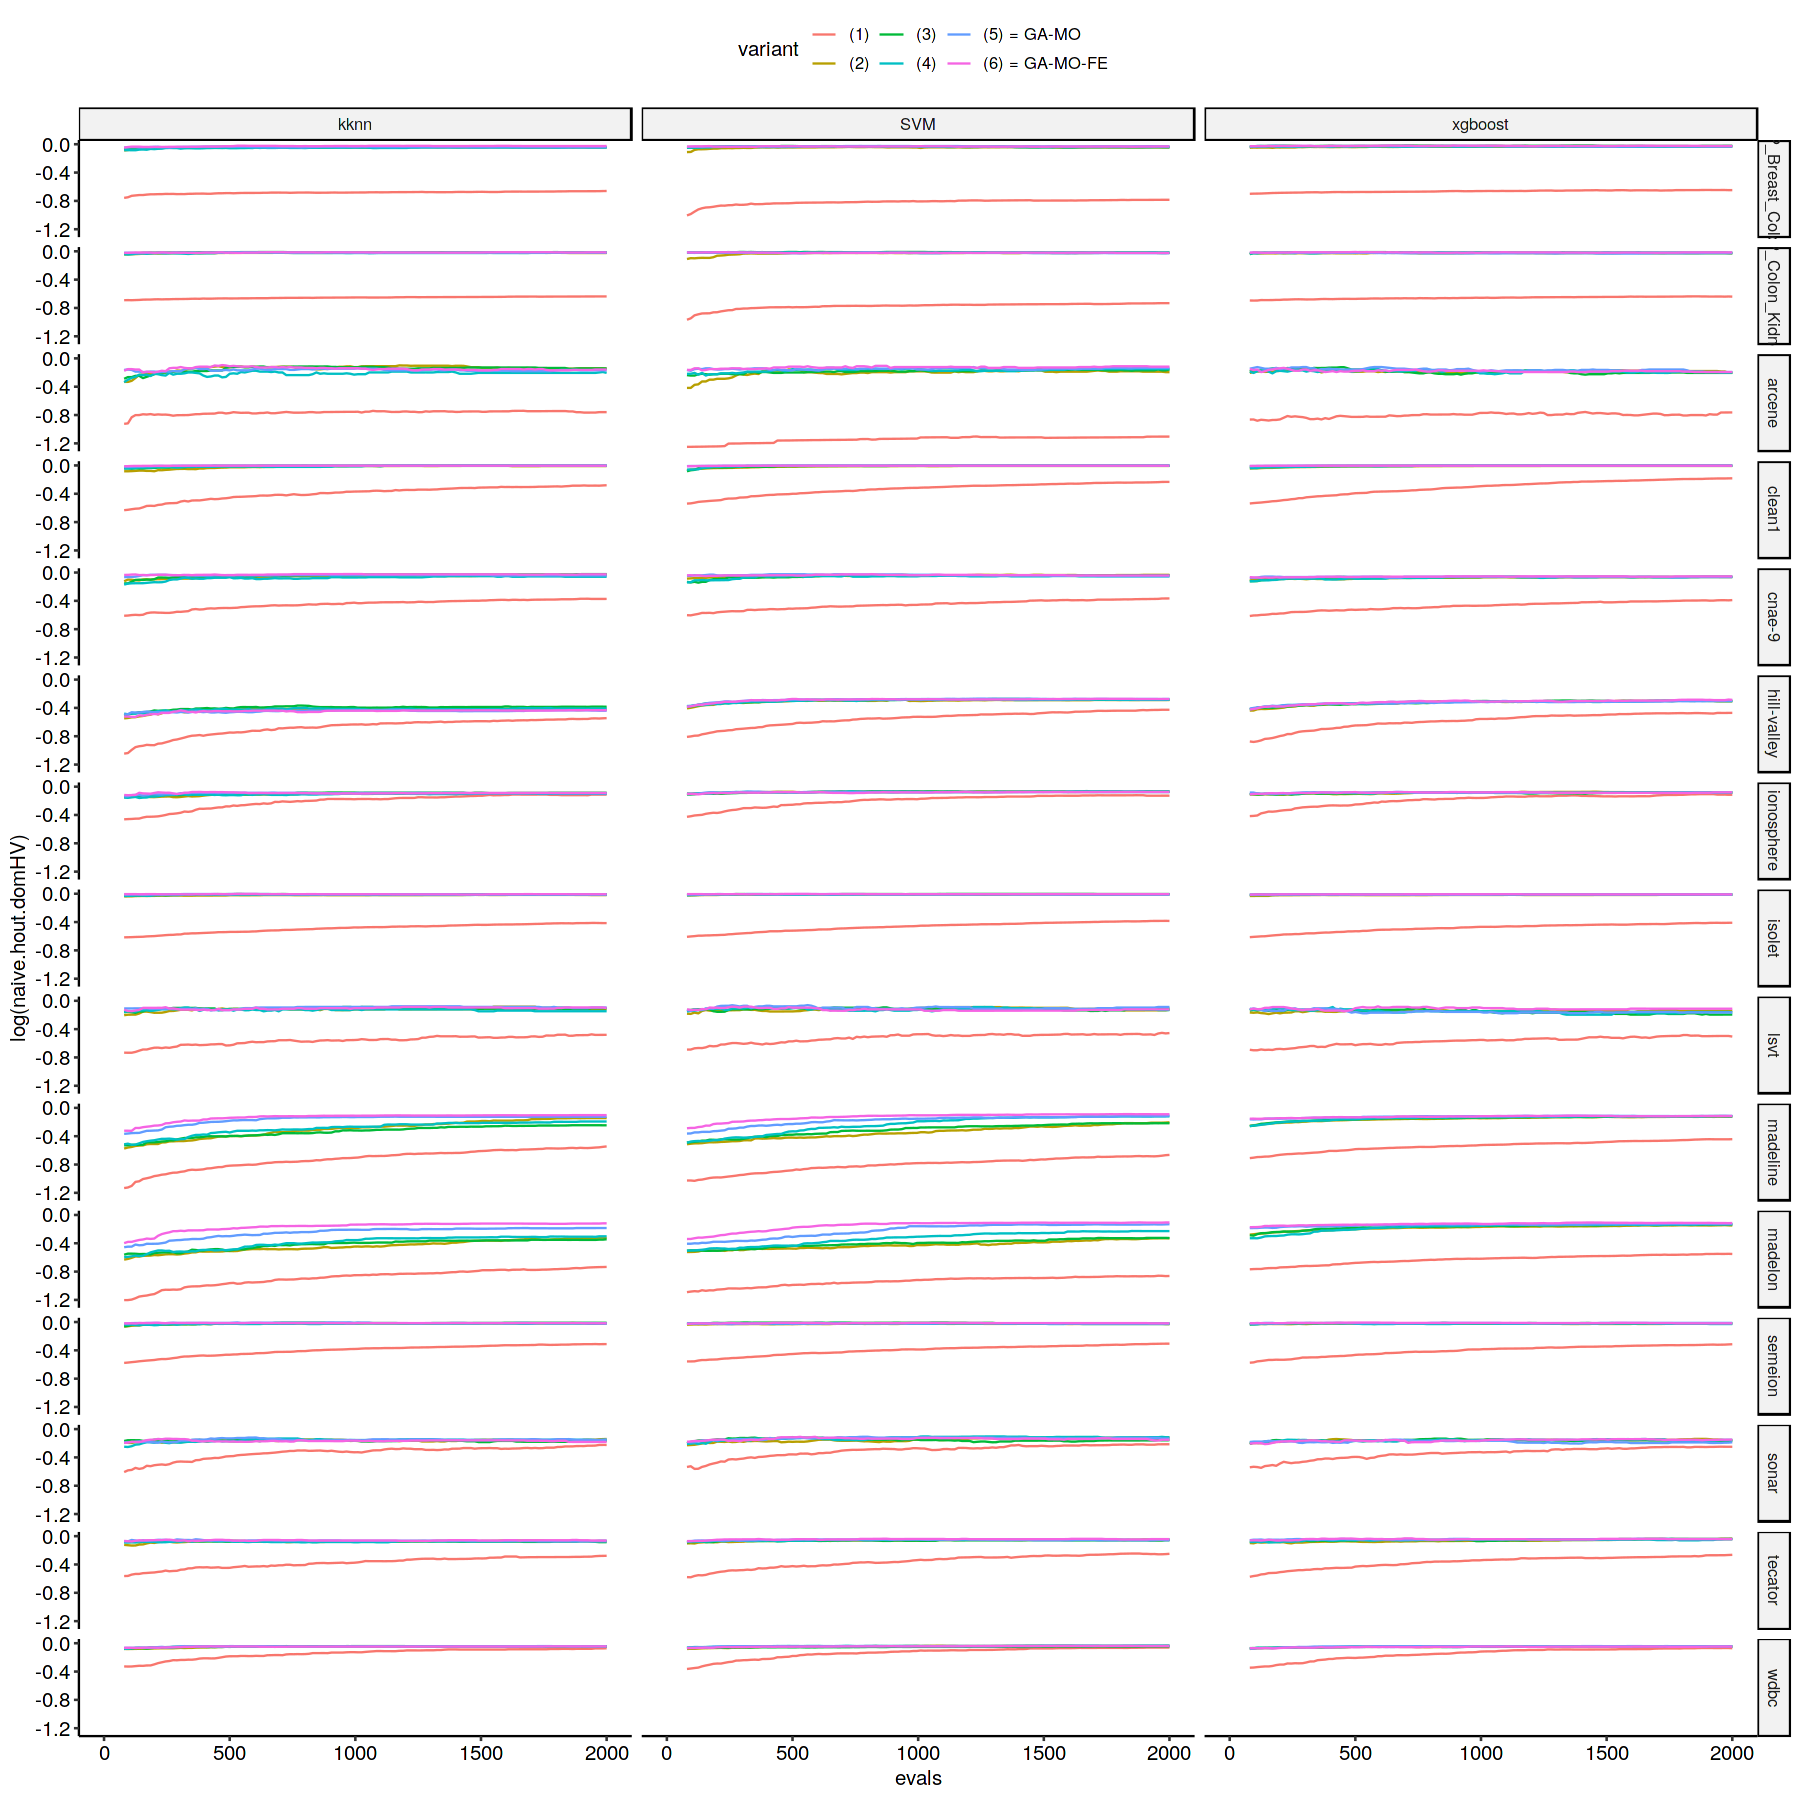

In [15]:
p = ggplot(data = dfp, aes(x = evals, y = log(naive.hout.domHV), colour = variant)) + geom_line() + xlim(c(0, 2000))
p = p + facet_grid(problem ~ learner)
p

In [16]:
plist = list()
for (prob in unique(dfp$prob)) {
    for (lrn in unique(dfp$learner)) {
        p = ggplot(data = dfp[problem == prob & learner == lrn, ], aes(x = evals, y = naive.hout.domHV, colour = variant)) + geom_line()
        p = p + ggtitle(paste(lrn, "on", prob)) + xlim(c(0, 2000))
        plist[[paste(prob, lrn, sep = ".")]] = p
    }
}

Warning message:
“Removed 268 rows containing missing values (geom_path).”


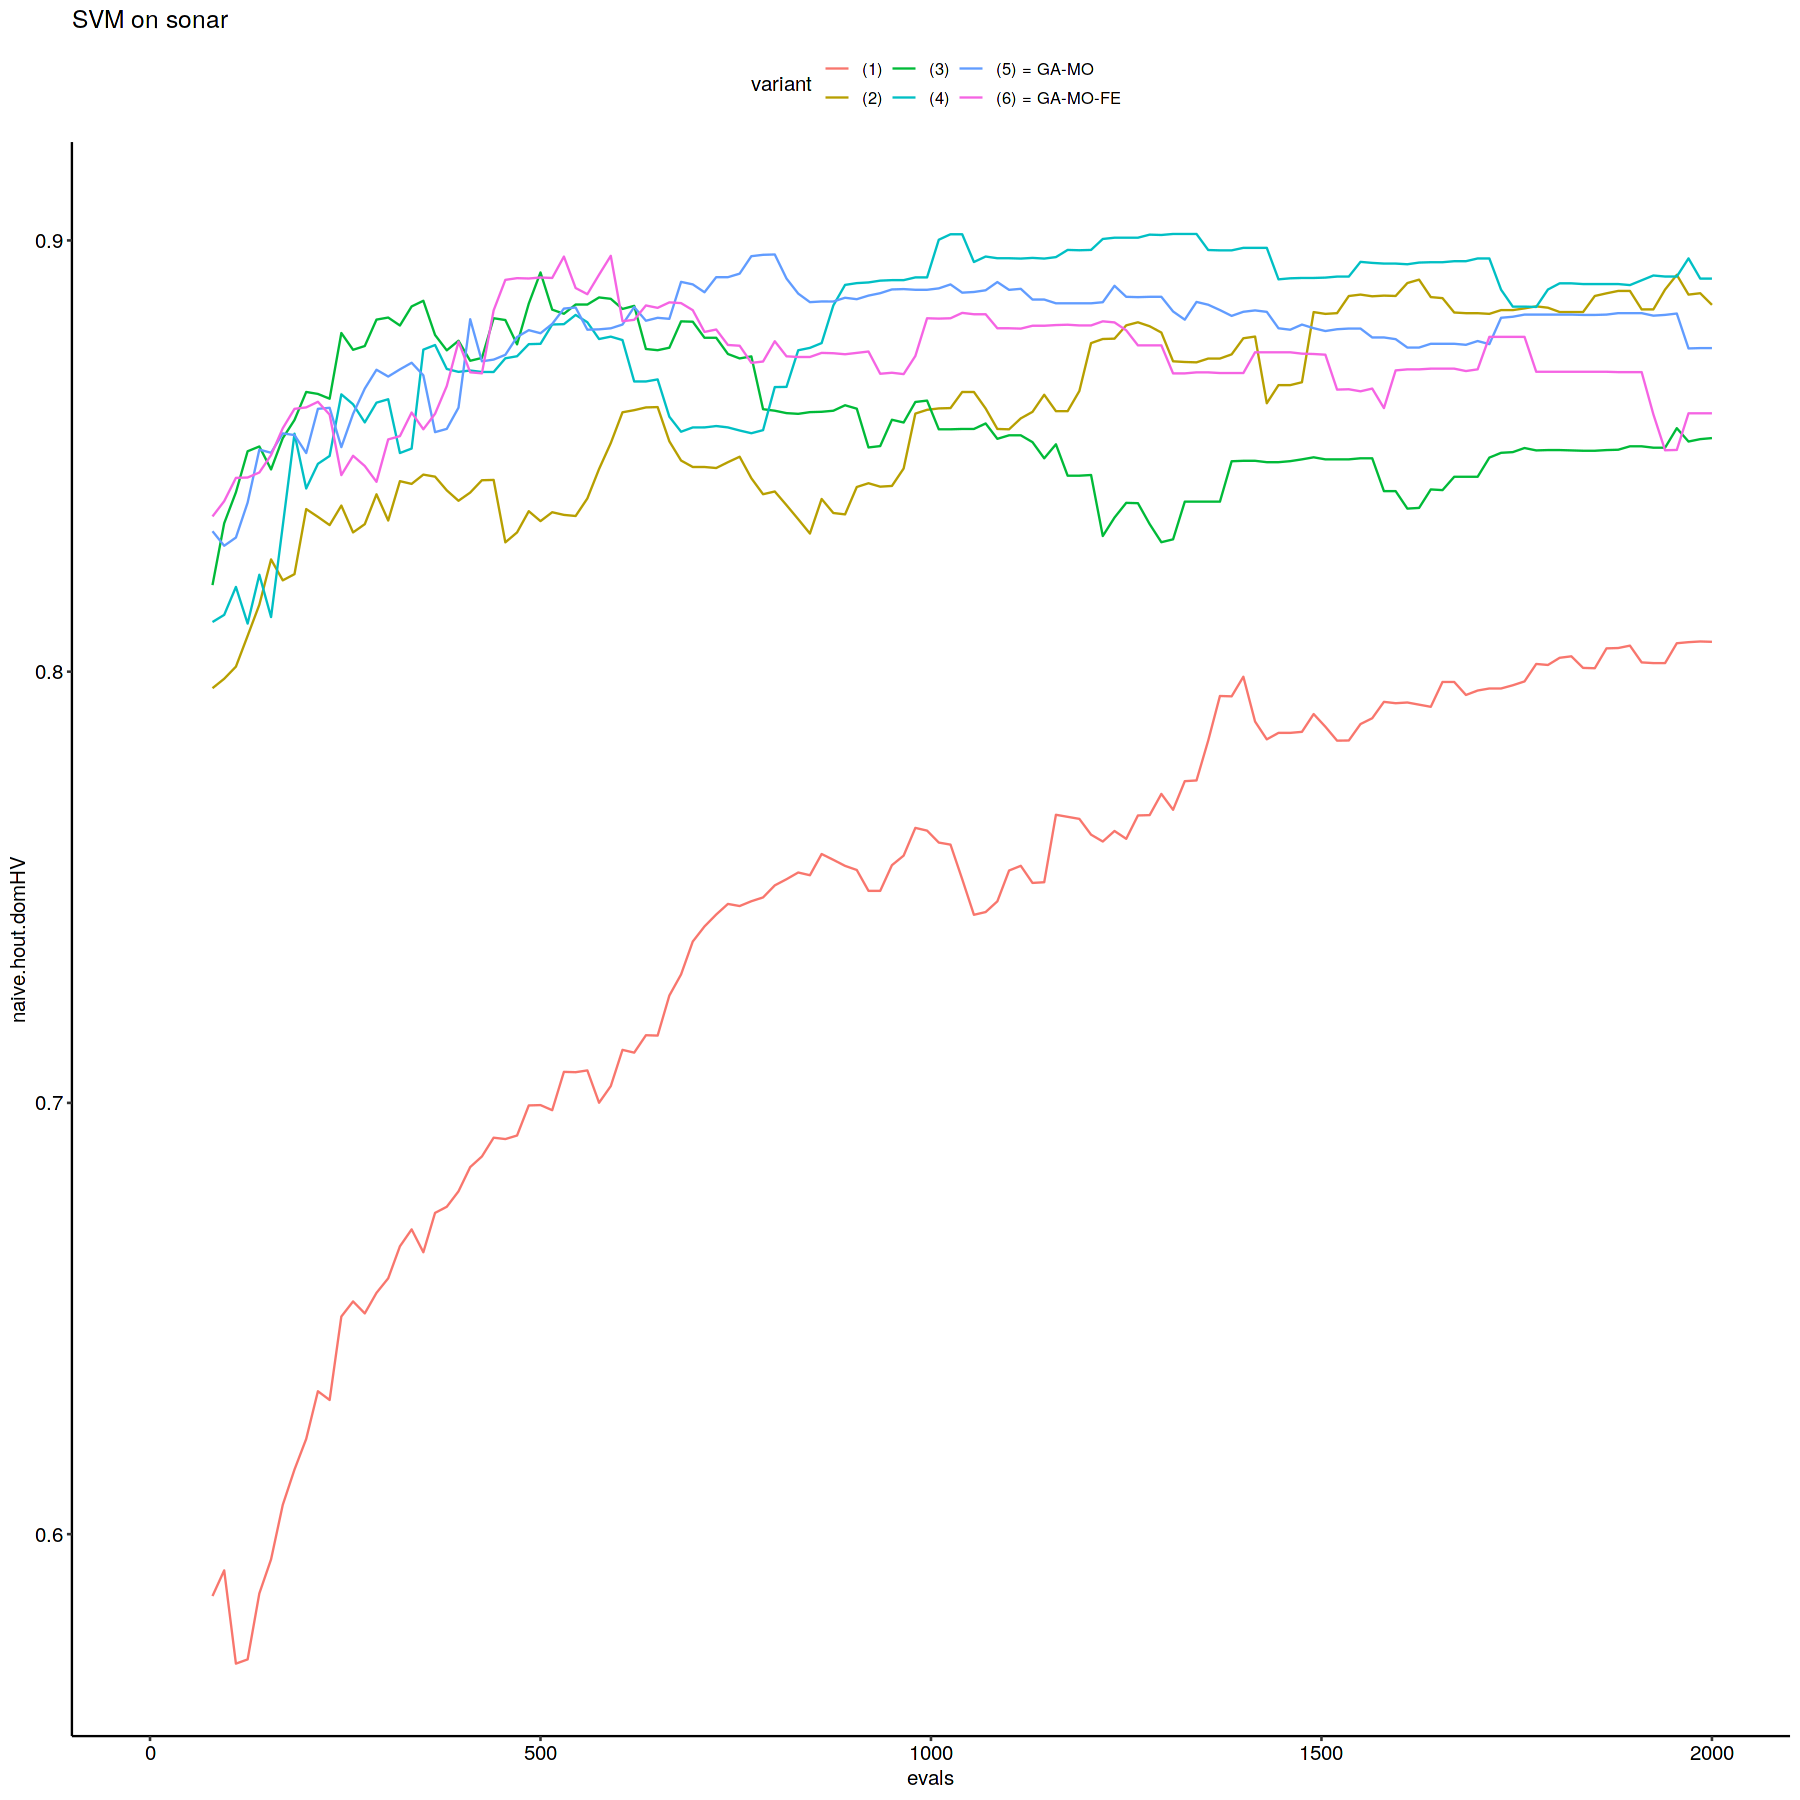

In [17]:
plist[[1]] 

### Significance Testing

In [28]:
for (measure in c("eval.domHV", "naive.hout.domHV", "true.hout.domHV")) {
    dfp$problem = paste(dfp$learner, dfp$problem, sep = "-")
    ev = 2000
    dfp = dfp[evals == ev, ]
    dft = dcast(dfp[, c("problem", "variant", ..measure)], problem ~ variant)
    rownames(dft) = dft$problem
    dft$problem = NULL
    m = gsub("\\.", "", measure)
    
    pdf(paste("viz/RQ0-CD_", m, ".pdf", sep = ""), width = 11, height = 4.5) 
    p = plotCD(dft, alpha = 0.05, cex = 1.25)
    p 
    dev.off()
    # ggsave(paste("viz/F1-Ablation-Study/CD_", measure, ".pdf"), p, width = 4.5, height = 4.5)
}


Using eval.domHV as value column: use value.var to override.

Using naive.hout.domHV as value column: use value.var to override.

Using true.hout.domHV as value column: use value.var to override.



### Rank Analysis

In [23]:
dfr = df[, .(meandomHV = mean(naive.hout.domHV)), by = c("learner", "variant", "problem", "evals")]

In [24]:
# average out replications first
dfr = df[, .(meandomHV = mean(naive.hout.domHV)), by = c("learner", "variant", "problem", "evals")]
# rank across all problems and learners
dfr = dfr[, `:=` (rank_variant = rank(meandomHV)), by = c("learner", "problem", "evals")]
# compute mean rank 
res_ovr = dfr[, .(mean.domHV = mean(meandomHV), mean.rank = mean(rank_variant), sd.domHV = sd(meandomHV) / sqrt(length(meandomHV))), by = c("evals", "variant")]

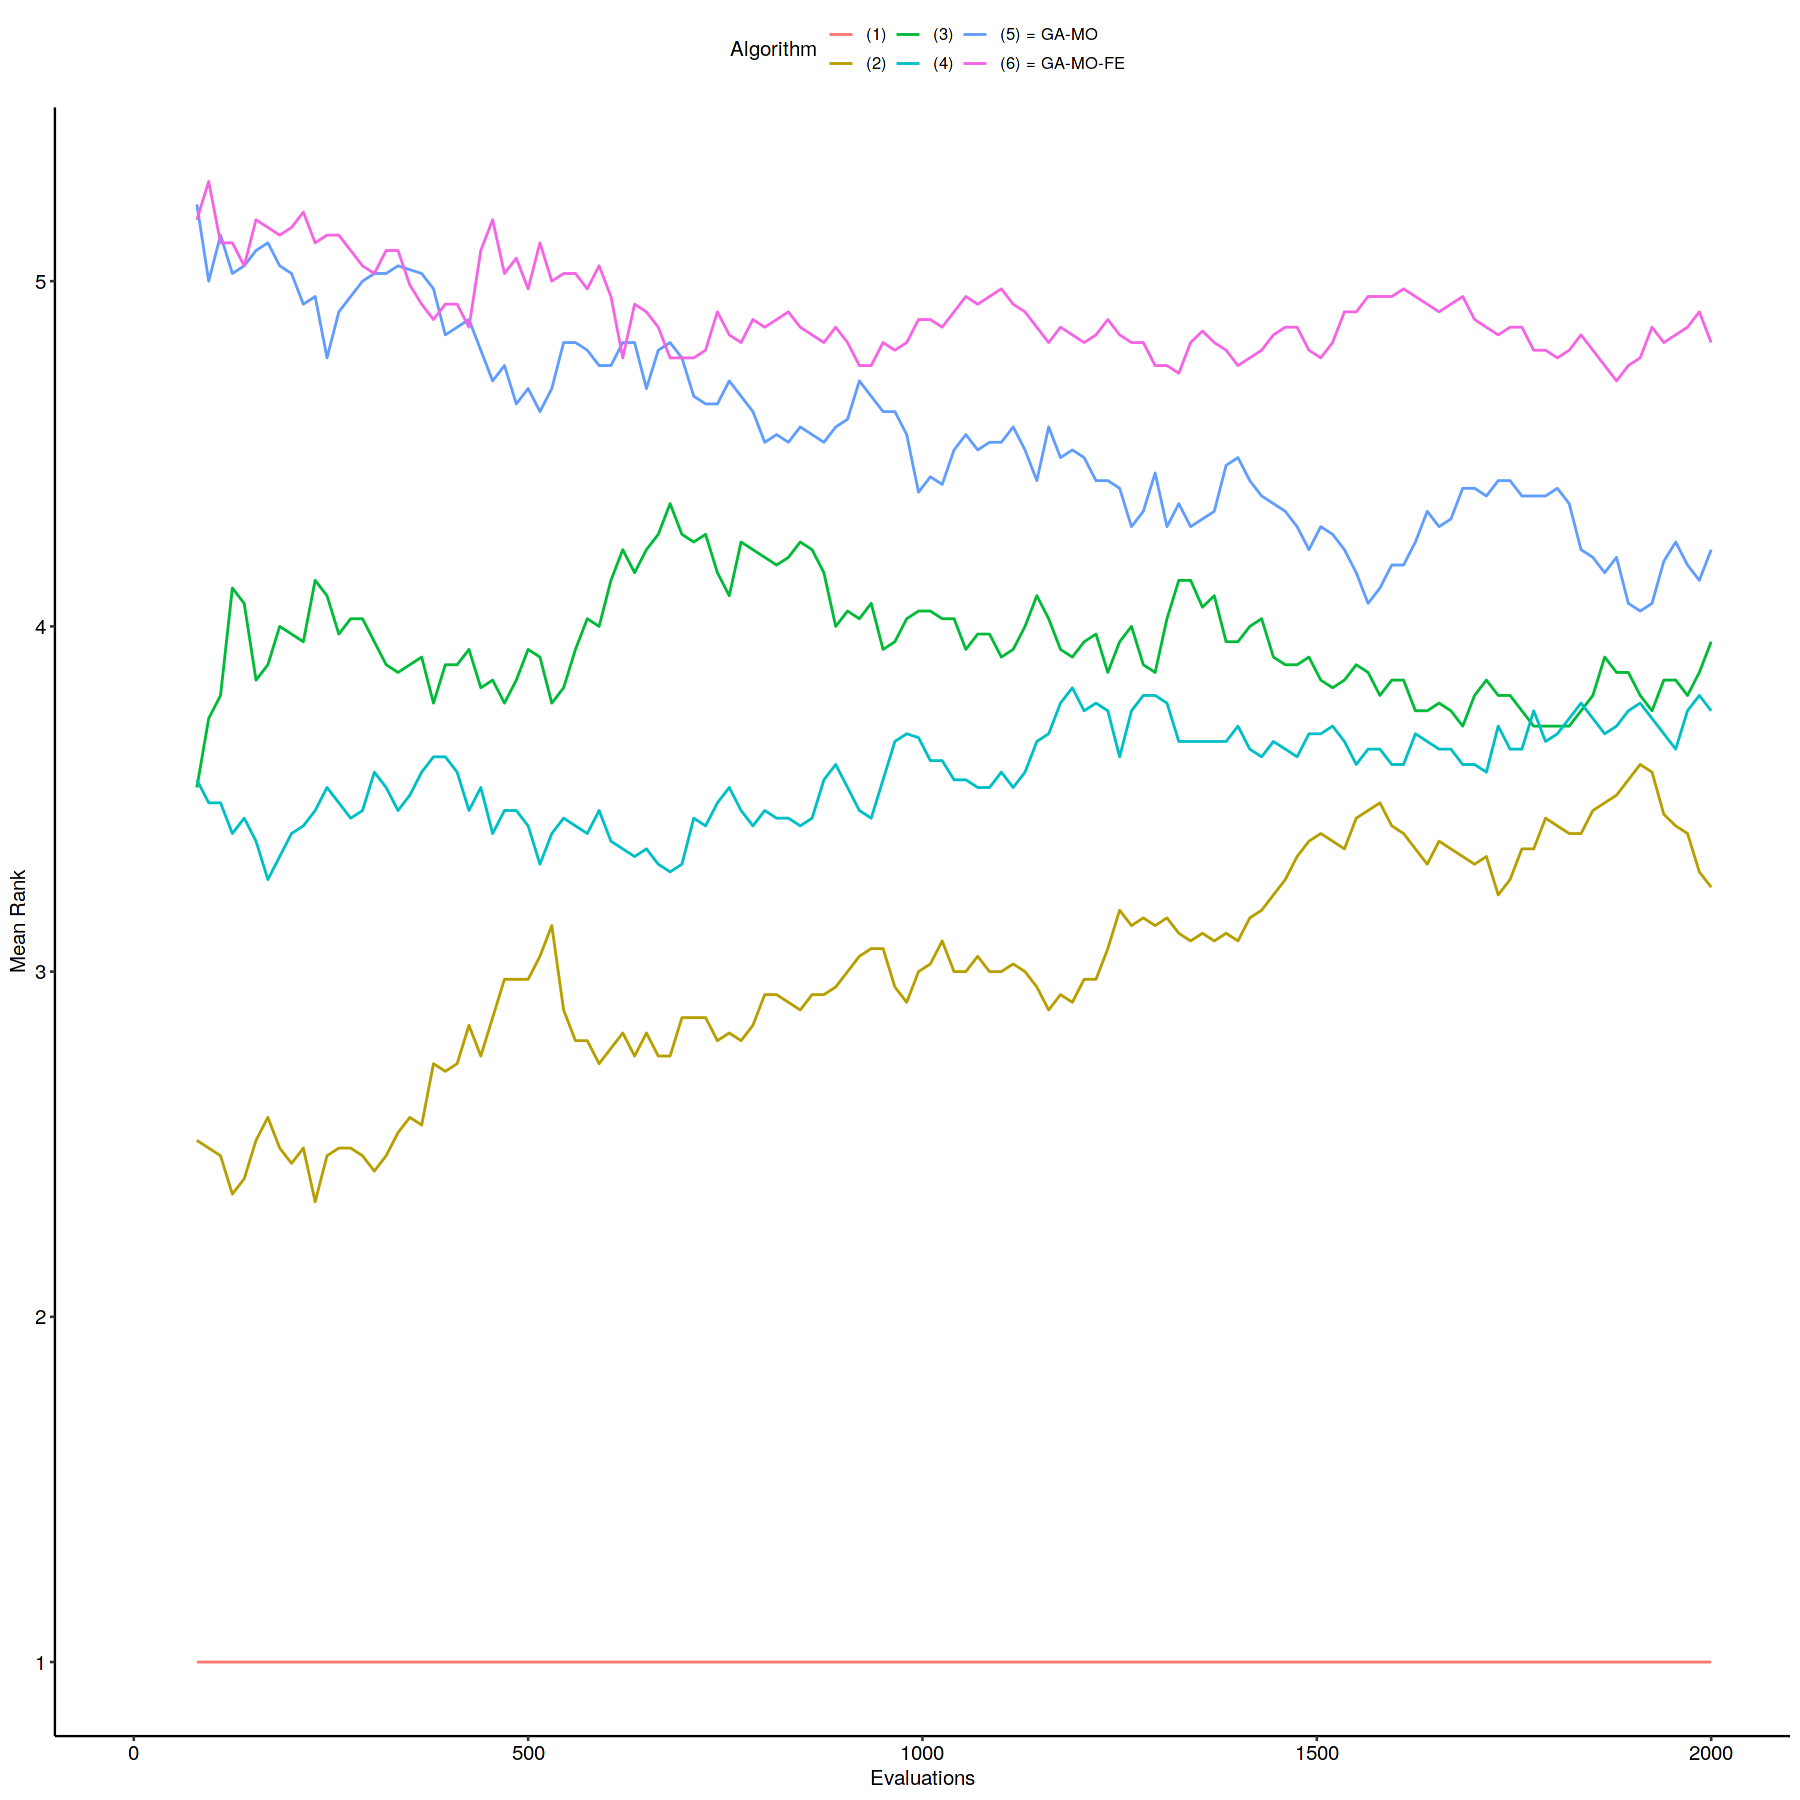

In [25]:
p1 = ggplot()
p1 = p1 + geom_line(data = res_ovr[evals <= 2000, ], aes(x = evals, y = mean.rank, colour = variant), size = 0.6)
p1 = p1 + labs(colour = "Algorithm") 
p1 = p1 + xlab("Evaluations") + xlim(c(0, 2000)) + ylab("Mean Rank") 
p1

In [26]:
ggsave("viz/RQ0-ranks_naive_domHV.pdf", p1, width = 7, height = 4.5)